# Figure: model comparison


In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from statsmodels.stats.multitest import multipletests
from himalaya.scoring import correlation_score

from util import plot, subject, stats
from util.path import Path
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS, BLU, ORG

import warnings
warnings.filterwarnings("ignore")

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
encmodel = "encoding_trialmot6"
cache = encmodel.split("_")[-1]
encmodel, cache

('encoding_trialmot6', 'trialmot6')

In [27]:
cachedir = f"cache/figure4-comparison/{cache}/"
!mkdir -p $cachedir

In [5]:
models = ['acoustic', 'articulatory', 'syntactic', 'static', 'contextual']

# within-subject encoding comparison

In [6]:
results = defaultdict(list)
prod_results = defaultdict(list)
comp_results = defaultdict(list)
for modelname in models:
    respath = Path(
        root=encmodel,
        sub="000",
        datatype=modelname,
        ext=".hdf5",
    )

    for sub in tqdm(SUBS_STRANGERS, desc=modelname):
        respath.update(sub=f"{sub:03d}")
        if not respath.isfile():
            print("skip", sub)
            continue
        with h5py.File(respath, "r") as f:
            results[modelname].append(np.mean(f['cv_scores_prod'][:, -2] + f['cv_scores_comp'][:, -1], axis=0))
            prod_results[modelname].append(np.mean(f['cv_scores_prod'][:, -2], axis=0))
            comp_results[modelname].append(np.mean(f['cv_scores_comp'][:, -1], axis=0))

for modelname in models:
    results[modelname] = np.stack(results[modelname])
    prod_results[modelname] = np.stack(prod_results[modelname])
    comp_results[modelname] = np.stack(comp_results[modelname])

contextual: 100%|██████████| 58/58 [00:09<00:00,  5.94it/s]


acoustic 0 0.07340537
articulatory 0 0.06702406
syntactic 0 0.030842748
static 0 0.05752295
contextual 0 0.10873678


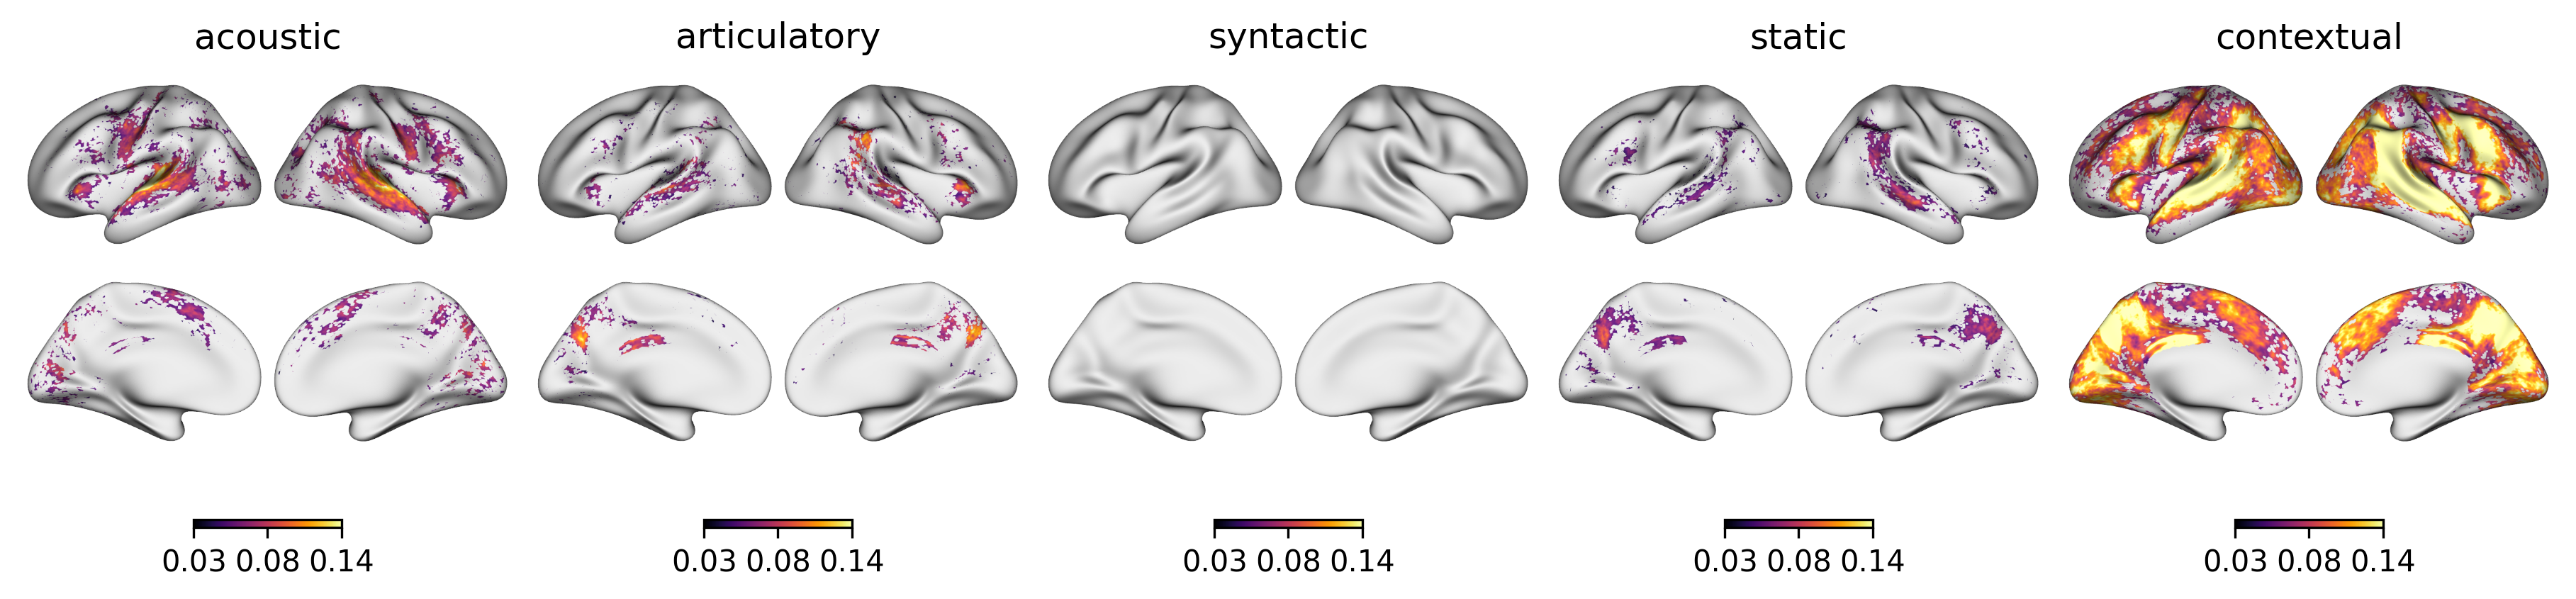

In [19]:
fig, axes = plt.subplots(1, len(models), figsize=(12, 4), layout='constrained', dpi=300)

for modelname, ax in zip(models, axes):

    sigmask = ~ stats.ttest_1samp(results[modelname], method='bonf', alpha=0.05)
    values = results[modelname].mean(0)
    min = 0 #values[~sigmask].min()
    print(modelname, min, values[~sigmask].mean())

    # values = prod_results[modelname].mean(0)
    # values = comp_results[modelname].mean(0)
    # sigmask = None

    plot.surface_plot(values, threshold=sigmask, fig=fig, ax=ax, vmin=0.03, vmax=0.14, cmap="inferno", title=modelname)

fig.show()

In [ ]:
mask =  get_brainmask()

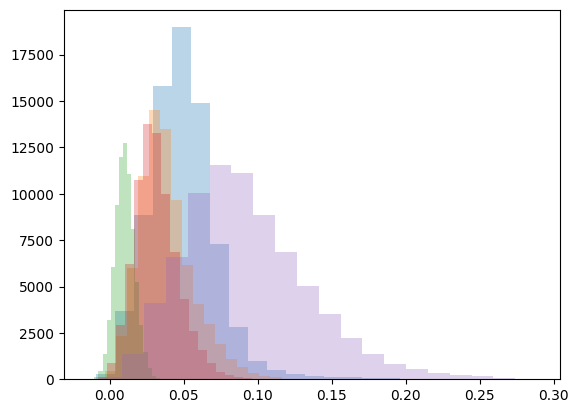

In [25]:
# https://seaborn.pydata.org/examples/kde_ridgeplot.html use instead
for modelname in models:
    values = results[modelname].mean(0)[mask]
    plt.hist(values, bins=20, alpha=0.3)
plt.show()

In [22]:
avg_results = {k: v.mean(0)[mask] for k, v in results.items()}
df = pd.DataFrame(avg_results)

<Axes: >

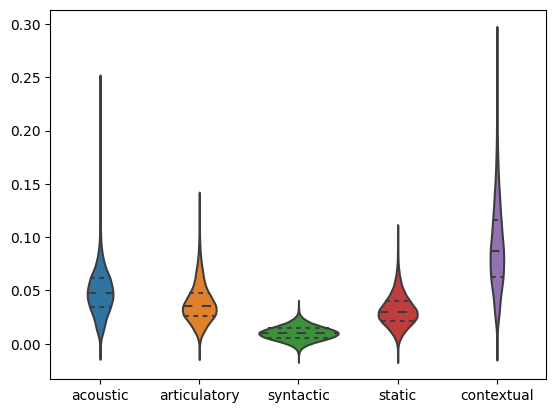

In [24]:
sns.violinplot(df, inner="quart", fill=False)

# MBC comparison

In [25]:
def get_mbc(modelname:str):
    mbc_scores = defaultdict(list)

    # use subA's predictions on subB's actual neural data
    for subA in tqdm(SUBS_STRANGERS):
        # load subA preds
        encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
        with h5py.File(encpath, "r") as f:
            prod_predA = f["cv_preds"][:, -2]  # (5, 6, 240, 81924)
            comp_predA = f["cv_preds"][:, -1]
            prodmaskA = f["cv_prodmask"][...]

        # load subB preds
        subB = subject.get_partner(subA)
        encpath = Path(root=encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
        with h5py.File(encpath, "r") as f:
            nuis_predsB = f["cv_preds"][:, :-2].sum(1)

        dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
        resB = dataB.reshape(5, 240, -1) - nuis_predsB

        compmaskA = ~prodmaskA

        for i in range(5):
            mbc_scores["prod"].append(correlation_score(prod_predA[i][prodmaskA[i]], resB[i][prodmaskA[i]]))
            mbc_scores["comp"].append(correlation_score(comp_predA[i][compmaskA[i]], resB[i][compmaskA[i]]))

    sub_mbc_prod = np.stack(mbc_scores["prod"])
    sub_mbc_comp = np.stack(mbc_scores["comp"])
    
    return sub_mbc_prod, sub_mbc_comp

In [26]:
results = []
for modelname in models:
    results.append(get_mbc(modelname))

100%|██████████| 58/58 [06:00<00:00,  6.22s/it]


In [28]:
# save
with h5py.File(f"{cachedir}/mbc.hdf5", "w") as f:
    for modelname, (prod, comp) in zip(models, results):
        f.create_dataset(name=f'{modelname}_prod', data=prod)
        f.create_dataset(name=f'{modelname}_comp', data=comp)

In [ ]:
# read
results = []
with h5py.File(f"{cachedir}/mbc.hdf5", "r") as f:
    for modelname in models:
        results.append((f[f'{modelname}_prod'], f[f'{modelname}_comp']))

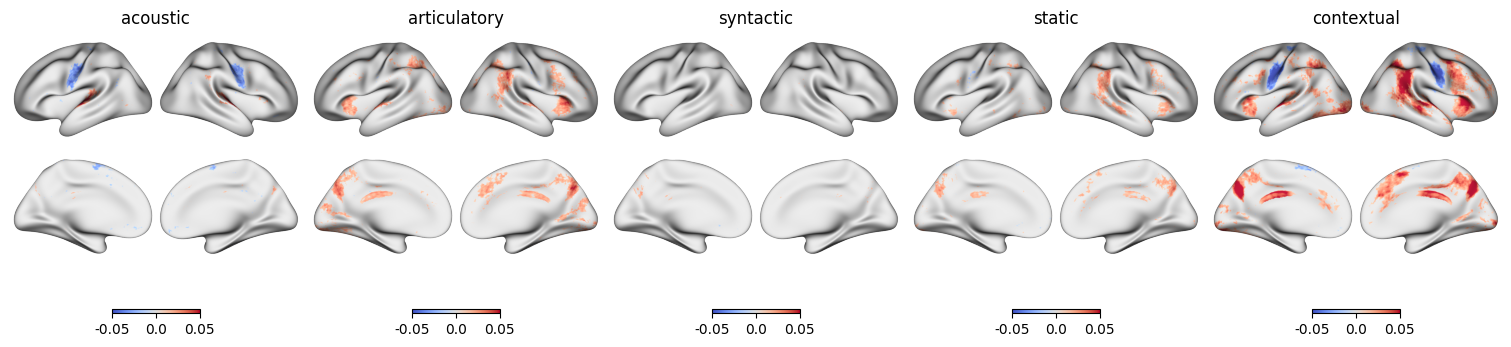

In [37]:
fig, axes = plt.subplots(1, len(models), figsize=(15, 6), layout='constrained')

for i, modelname, result, ax in zip(range(len(models)), models, results, axes):
    values = (result[0] + result[1]) / 2
    sigmask = ~ stats.ttest_1samp(values, method='fdr_by', alpha=0.05)
    plot.surface_plot(values.mean(0), threshold=sigmask, fig=fig, ax=ax, vmax=0.05, cmap="coolwarm", title=modelname)

fig.show()